In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg' 

Populating the interactive namespace from numpy and matplotlib


In [2]:
import group_data as gd
import flylib
import pylab as plb
calc_new_stats = False
plb.rcParams['pdf.fonttype'] = 42

In [3]:
#import seaborn as sns

In [4]:
if calc_new_stats:
    import flylib
    import db_access as dba
    fly_db = dba.get_db()

    def wing_correlations_df(sig,imgs,fly = None):
        #calculate some summary images including the correlation image
        include = isfinite(sig)
        sig = sig[include]
        imgs = imgs[include]
        #now calculate stats
        mean_img = mean(imgs,axis=0)
        zeroed_img = imgs - mean_img

        max_img = np.max(imgs,axis = 0)
        norm_img = numpy.linalg.norm(zeroed_img,axis = 0)
        norm_sig = numpy.linalg.norm(sig-np.mean(sig))
        dot_img = sum(zeroed_img*(sig[:,newaxis,newaxis]-np.mean(sig)),axis = 0)
        corr_img = dot_img/(norm_img*norm_sig)
        return {'mean_img':mean_img,
            'max_img':max_img,
            'norm_img':norm_img,
            'dot_img':dot_img,
            'corr_img':corr_img}

    def imgs_stats_df(fly = None):
        #get signals from fly
        rwing = np.array(fly.experiments.values()[0].exp_record['tiff_data']['axon_framebase']['Ph1'])
        lwing = np.array(fly.experiments.values()[0].exp_record['tiff_data']['axon_framebase']['Ph0'])
        wbf = np.array(fly.experiments.values()[0].exp_record['tiff_data']['axon_framebase']['wb_frequency'])
        StimCond = np.array(fly.experiments.values()[0].exp_record['tiff_data']['axon_framebase']['StimCond'])
        images = np.array(fly.experiments.values()[0].exp_record['tiff_data']['images'])
        mask = ((StimCond<0) & (wbf >150))[:shape(images)[0]]
        #load baseline data
        fi = open(fly.fly_path + 'epoch_data.cpkl')
        import cPickle
        baseline_range = cPickle.load(fi)['baseline_F']
        fi.close()
        F = np.mean(images[baseline_range],axis = 0)
        #calculate dF/F
        imgs = (images[mask]-F)/F
        #print sum(mask)
        return {'lwing':wing_correlations_df(lwing[mask],imgs),
                'rwing':wing_correlations_df(rwing[mask],imgs),
                'freq':wing_correlations_df(wbf[mask],imgs)}

    test_group = range(405,422)#[397,399,400,401,402,403,404]#range(396,399) #range(317,326)

    test_swarm = flylib.Squadron(fly_db,test_group)#GMR29E05_swarm

    swarm_list = [test_swarm]

    import cPickle
    for swarm in swarm_list:
        for fly in swarm.flies:
            #print fly.fly_num
            try:
                stats = imgs_stats_df(fly = fly)
                fi = open(fly.fly_path + 'img_stats_df.cpkl','wb')
                cPickle.dump(stats,fi)
                fi.close()
            except IOError:
                print fly.fly_num

        for fly in swarm.flies:
            try:
                fi = open(fly.fly_path + 'img_stats_df.cpkl','rb')
                stats = cPickle.load(fi)
                fi.close()
                figure()
                imshow(stats['rwing']['corr_img'].reshape(130,174),cmap = cm.gray)
            except IOError:
                print fly.fly_num

## Load the reference frame data and make correlation plots

In [24]:
def kill_spines(top = True,bottom =True, left = True,right=True):
    if top:
        plb.gca().spines['top'].set_visible(False)
        #[x.set_visible(False) for x in plb.gca().get_xticklabels()]
        [x.set_visible(False) for x in plb.gca().get_xticklines()[1::2]]
    if right:
        plb.gca().spines['right'].set_visible(False)
        #[y.set_visible(False) for y in plb.gca().get_yticklabels()]
        [y.set_visible(False) for y in plb.gca().get_yticklines()[1::2]]
    if left:
        plb.gca().spines['left'].set_visible(False)
        [y.set_visible(False) for y in plb.gca().get_yticklabels()]
        [y.set_visible(False) for y in plb.gca().get_yticklines()[::2]]
    if bottom:
        plb.gca().spines['bottom'].set_visible(False)
        [x.set_visible(False) for x in plb.gca().get_xticklabels()]
        [x.set_visible(False) for x in plb.gca().get_xticklines()[::2]]
        
    #plb.gca().set_ybound(-0.1,1.8)
    
    #.set_visible(False)
    
    

In [9]:
import muscle_model as mm
reload(mm)
confocal_model = mm.GeometricModel(filepath = 'model_data.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)

def warp_fly_image(fly,img,s = 1):
    import cv2
    import cPickle
    pkname = fly.fly_path + '/basis_fits.cpkl'
    fly_frame = mm.Frame();fly_frame.load(pkname)
    A = confocal_model.frame.get_transform(fly_frame)
    Ap = dot([[s,0.0,0],[0,s,0],[0,0,1]],A)
    output_shape = (np.array([1024,1024])*s).astype(int) #confocal shape scale
    output_shape = (output_shape[0],output_shape[1])
    X_warped = cv2.warpAffine(img.T,Ap[:-1,:],output_shape)
    return X_warped

def get_swarm_summary(swarm):
    import cPickle
    corr_list = list()
    norm_list = list()
    freq_list = list()
    for fly in swarm.flies:
        try:
            f = open(fly.fly_path + 'img_stats_df.cpkl','rb')
            stats = cPickle.load(f)
            f.close()
            corr_list.append([fly,stats['rwing']['corr_img'].reshape(130,174)*stats['rwing']['norm_img'].reshape(130,174)])
            norm_list.append([fly,stats['rwing']['norm_img'].reshape(130,174)])
            freq_list.append([fly,stats['freq']['corr_img'].reshape(130,174)*stats['rwing']['norm_img'].reshape(130,174)])
        except IOError:
            print fly.fly_num
    warped_imgs = list()
    for fly,img in norm_list:
        warped_imgs.append(warp_fly_image(fly,img))
    group_norm = mean(dstack(warped_imgs),axis = 2)
    
    warped_imgs = list()
    for fly,img in corr_list:
        warped_imgs.append(warp_fly_image(fly,img))
    group_corr = mean(dstack(warped_imgs),axis = 2)
        
    warped_imgs = list()
    for fly,img in freq_list:
        warped_imgs.append(warp_fly_image(fly,img))
    group_freq_corr = mean(dstack(warped_imgs),axis = 2)
    
    return(group_norm,group_corr,group_freq_corr)


    
def plot_swarm_corr(swarm,contour_kwargs = None,
                    line_name = None,
                    plot_pans = None,
                    norm_vmin = -1.0,norm_vmax = 1.0,
                    cov_amp_vmin = -1.0,cov_amp_vmax = 1.0,
                    cov_freq_vmin = -1.0,cov_freq_vmax = 1.0,
                    xbounds = None,ybounds = None,cmap = plb.cm.gray):
    line_label = line_name
    plb.axes(plot_pans[0])
    import os
    filelist = os.listdir('./')
    #line_name = line_name.split('_GFP')[0].split('GMR')[1]
    #antibody_file = filter(lambda x: (line_name in x) and ('(RGB)' in x),filelist)[0]
    #print antibody_file
    #import tifffile
    #tfile = tifffile.TiffFile(antibody_file)
    #antibody_image = tfile.asarray()
    #imshow(antibody_image)
    line_model = confocal_model.get_masks_by_line(confocal_model.frame,(1024,1024),line_name = line_label)[0]
    line_model = line_model.reshape(-1,1024,1024)
    plb.imshow(np.sum(line_model,axis = 0).T,cmap = plb.cm.gray)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    gca().set_title(line_label)
    kill_spines()
    gca().set_xbound(xbounds)
    gca().set_ybound(ybounds)
    
    group_norm,group_corr,group_freq_corr = get_swarm_summary(swarm)

    axes(plot_pans[1])
    if norm_vmin is None:
        vman = np.nanmean(group_norm.ravel()) + np.nanstd(group_norm.ravel())*1
        vmin = 0

    imshow(group_norm,cmap = cmap,vmin = vmin,vmax = vmax)
    #subplot(1,2,1)
    #plot_args = {'plot_frame':False,'contour_kwargs':{'edgecolor':'y','alpha':0.5,'facecolor':'none'}}
    plot_args = {'draw_frame':False,'contour_kwargs':contour_kwargs}
    #confocal_view.plot(confocal_model.frame,**plot_args)
    #gca().set_xbound(0,1000)
    #gca().set_ybound(0,1000)
    gca().set_xbound(xbounds)
    gca().set_ybound(ybounds)
    kill_spines()
    #gca().set_title('std image')
    
    #subplot(1,2,2)
    axes(plot_pans[2])
    if cov_amp_vmin is None:
        #vman = np.nanmean(group_corr.ravel()) + np.nanstd(group_corr.ravel())*4
        #vmin = np.nanmean(group_corr.ravel()) - np.nanstd(group_corr.ravel())*4
        vman = 0 + np.nanstd(group_corr.ravel())*4
        vmin = 0 - np.nanstd(group_corr.ravel())*4
    
    imshow(group_corr,cmap = cmap,vmin = vmin,vmax = vmax)
    #print np.min(mean(dstack(warped_imgs),axis = 2))
    #plot_args = {'draw_frame':False,'contour_kwargs':contour_kwargs}
    #confocal_view.plot(confocal_model.frame,**plot_args)
    #gca().set_xbound(0,1000)
    #gca().set_ybound(0,1000)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    gca().set_xbound(xbounds)
    gca().set_ybound(ybounds)
    kill_spines()
    
    axes(plot_pans[3])
    if cov_freq_vmin is None:
        vman = np.nanmean(group_freq_corr.ravel()) + np.nanstd(group_freq_corr.ravel())*4
        vmin = np.nanmean(group_freq_corr.ravel()) - np.nanstd(group_freq_corr.ravel())*4
        
    imshow(group_freq_corr,cmap = cmap,vmin = vmin,vmax = vmax)
    #print np.min(mean(dstack(warped_imgs),axis = 2))
    #plot_args = {'draw_frame':False,'contour_kwargs':contour_kwargs}
    #confocal_view.plot(confocal_model.frame,**plot_args)
    #gca().set_xbound(0,1000)
    #gca().set_ybound(0,1000)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    gca().set_xbound(xbounds)
    gca().set_ybound(ybounds)
    kill_spines()
    #gca().set_title('correlation image')
    
    #suptitle(line_name)
    
def get_kwargs(line_name):
    import cPickle
    f = open('../../../mn_expression_matrix_plot/line_database.cpkl','rb')
    line_database = cPickle.load(f)
    f.close()
    contour_kwargs = dict()
    line_name = line_name.split('_GFP')[0].split('GMR')[1]
    for key in line_database[line_name].keys():
        if 'DVM' in key:
            contour_kwargs['DVM1'] = {'linewidth':line_database[line_name]['DVM']/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
            contour_kwargs['DVM2'] = {'linewidth':line_database[line_name]['DVM']/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
            contour_kwargs['DVM3'] = {'linewidth':line_database[line_name]['DVM']/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
        else:
            contour_kwargs[key] = {'linewidth':line_database[line_name][key]/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
    return contour_kwargs

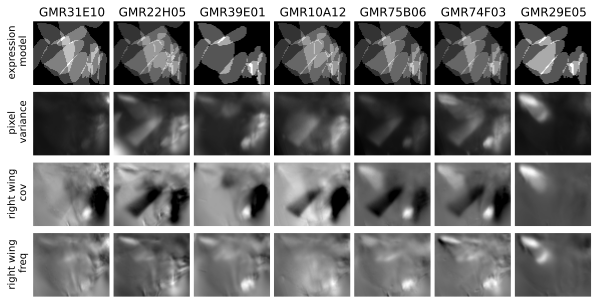

In [57]:
from matplotlib import gridspec

vmin = None#-20.5
vmax = None#20.5
xmin = 60
xmax = 750
xbounds = (xmin,xmax)
ymin = 325
ymax = 900
ybounds = (ymin,ymax)
fig = plb.figure(figsize = (10,5))
gmrlines = gd.exp_swarms#['GMR22H05','GMR74F03','GMR75B06','GMR29E05','GMR31E10','GMR39E01']
gs = gridspec.GridSpec(4,len(gmrlines))
for i,line_name in enumerate(gmrlines):
    plot_pans = [subplot(gs[row,i]) for row in range(4)]
    if i == 0:
        axes(plot_pans[0])
        gca().set_ylabel('expression\n model')
        axes(plot_pans[1])
        gca().set_ylabel('pixel\n variance')
        axes(plot_pans[2])
        gca().set_ylabel('right wing\n cov')
        axes(plot_pans[3])
        gca().set_ylabel('right wing\n freq')
        
        
    contour_kwargs = get_kwargs(line_name = line_name)
    plot_swarm_corr(gd.swarms[line_name],
                    contour_kwargs,
                    line_name = line_name,
                    plot_pans = plot_pans,
                    norm_vmin = None,norm_vmax = None,
                    cov_amp_vmin = None,cov_amp_vmax = None,
                    cov_freq_vmin = None,cov_freq_vmax = None,
                    xbounds = xbounds,ybounds = ybounds,
                    cmap = cm.gray)
    #savefig(line_name + '_corr' + '.pdf')
    #close()
plt.subplots_adjust(hspace = .05)
plt.subplots_adjust(wspace = .05)
savefig('correlation_images.pdf')

In [13]:
fly = gd.exp_swarms['GMR22H05'].flies[0]

file missing


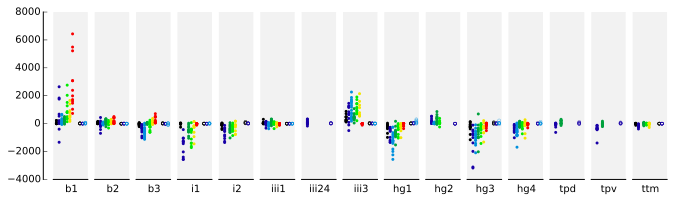

In [69]:
fig = plb.figure(figsize = (11,3))
muscle_list = ['b1','b2','b3','i1','i2','iii1','iii24','iii3','hg1','hg2','hg3','hg4','tpd','tpv','ttm']
cmap = plb.cm.spectral

from matplotlib import gridspec
gs = GridSpec(1,len(muscle_list))
pans = [plb.subplot(gs[0,i],sharey = plb.gca(),sharex = plb.gca()) for i,m in enumerate(muscle_list)]
cmax = len(gd.exp_swarms.values())

for cidx,swarm in enumerate(gd.exp_swarms.values()):
    #plb.subplot(7,1,cidx+1,sharey = plb.gca(),sharex = plb.gca())
    cval = float(cidx)/cmax
    offset = cidx*10000
    for fly in swarm.flies:
        try:
            pkldata = fly.get_pkl_data('nnls_fits_no_bk_dF_F_corr_data.cpkl')
            zero_idx = argwhere(pkldata['times']>0)[0]
            for i,mkey in enumerate(muscle_list):
                plb.axes(pans[i])
                try:
                    plb.plot((cval*1.2),pkldata[mkey][zero_idx][0],
                             'o',color = cmap(cval), alpha = 0.5,ms = 3.0,markeredgecolor  = 'none')
                    #plb.plot((i*2)+2,pkldata[mkey][zero_idx][0]+offset,
                    #         'o',color = plb.cm.jet(cval), alpha = 0.2,ms = 5.0,markeredgecolor  = 'none')
                except KeyError:
                    pass#print mkey
            #kill_spines()
        except IOError:
            print 'file missing'

for cidx,swarm in enumerate(gd.ctrl_swarms.values()):
    #plb.subplot(7,1,cidx+1,sharey = plb.gca(),sharex = plb.gca())
    cval = float(cidx)/cmax
    offset = cidx*10000
    for fly in swarm.flies:
        try:
            pkldata = fly.get_pkl_data('nnls_fits_no_bk_dF_F_corr_data.cpkl')
            zero_idx = argwhere(pkldata['times']>0)[0]
            for i,mkey in enumerate(muscle_list):
                plb.axes(pans[i])
                try:
                    c = cmap(cval)
                    c = (c[0],c[1],c[2],0.6)
                    plb.plot((cval*1.2)+1.5,pkldata[mkey][zero_idx][0],
                             'o',color = cmap(cval),ms = 3.0,markeredgecolor = c,markerfacecolor = 'none')
                    #plb.plot((i*2)+2,pkldata[mkey][zero_idx][0]+offset,
                    #         'o',color = plb.cm.jet(cval), alpha = 0.2,ms = 5.0,markeredgecolor  = 'none')
                except KeyError:
                    pass#print mkey
            #kill_spines()
        except IOError:
            pass#print 'file missing'
for i,pan in enumerate(pans):
    plb.axes(pan)
    if i == 0:
        kill_spines(bottom = False,left=False)
        spns = gca().spines
        spns['left'].set_position(('outward', 10))
        [y.set_visible(False) for y in plb.gca().get_yticklines()[1::2]]
    else:
        kill_spines(bottom = False)
    gca().set_xlabel(muscle_list[i])
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [x.set_visible(False) for x in plb.gca().get_xticklines()[::2]]
    gca().set_axis_bgcolor((0.95,0.95,0.95))
    #[x.set_visible(False) for x in plb.gca().get_xticklines()]

gca().set_xbound(-0.2,2.0)
    #gca().set_xbound(-2,len(muscle_list)*3+2)
    #gca().set_xticks((np.arange(len(muscle_list))*3))
    #gca().set_xticklabels(muscle_list)
plb.savefig('corr_quant.pdf')

In [75]:
msks = confocal_model.get_masks(confocal_model.frame,(1024,1024))

In [100]:
confocal_model.get_masks_by_line(confocal_model.frame,(512,512),line_name = 'GMR22H05')

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]]),
 array([False, False, False, ...,  True,  True,  True], dtype=bool))

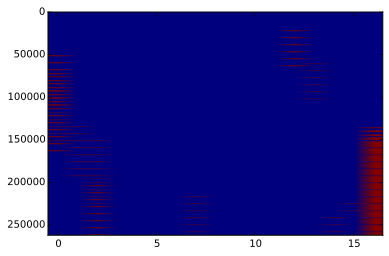

In [102]:
imshow(Out[100][0][:-1].T,aspect = 'auto')